In [4]:
# !pip install update xarray 
# !pip install cmocean 
# ! pip install netcdf4
# ! pip install cftime
# ! pip install hdf5
# !  pip install nc-time-axis
# ! pip install wget
# ! pip install matplotlib
# ! pip install intake
# ! pip  install zarr
# ! pip install dask
# ! pip install tqdm
# ! pip install nc_time_axis
# ! pip install cmip6_preprocessing
# ! pip install gcsfs
! apt-get -qq install python-cartopy python3-cartopy
! python -m pip install intake-esm
# ! conda install -c conda-forge xesmf esmpy=7.1.0 --y




E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [7]:
%matplotlib inline
import numpy as np
import gcsfs
import pandas as pd
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import intake_esm
# import cartopy
# from cartopy import util
# import cartopy.crs as ccrs
import zarr
import dask.array as da  
from dask.diagnostics import ProgressBar
from tqdm.autonotebook import tqdm
import nc_time_axis
import time
import xesmf as xe
import cmip6_preprocessing
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from ipykernel import kernelapp as app


In [8]:
from cmip6_preprocessing.preprocessing import combined_preprocessing, replace_x_y_nominal_lat_lon, rename_cmip6

def wrapper(ds):
    ds = ds.copy()
    #ds = rename_cmip6(ds)
    #ds = replace_x_y_nominal_lat_lon(ds)
    
    if ('longitude' in ds.dims):
        ds = ds.rename({'longitude':'lon'}) # some models labelled dimensions differently...
    if ('latitude' in ds.dims):    
        ds = ds.rename({'latitude': 'lat'})

    #------------experimental---------- 
    
    if ('nav_lon' in ds.dims):
        ds = ds.rename({'nav_lon':'lon'}) # some models labelled dimensions differently...
    if ('nav_lat' in ds.dims):    
        ds = ds.rename({'nav_lat': 'lat'})
    if ('vertices' in ds.dims): 
        ds=ds.drop_dims('vertices')   
    if ('nvertex' in ds.dims): 
        ds=ds.drop_dims('nvertex') 
    if ('axis_nbounds' in ds.dims): 
        ds=ds.drop_dims('axis_nbounds')       
    #-----------------------------------    
        
    if ('bnds' in ds.dims): 
        ds=ds.drop_dims('bnds')
    if ('vertex' in ds.dims): 
        ds=ds.drop_dims('vertex')
    if ('height' in ds.dims): 
        ds=ds.drop_dims('height')
    if ('height' in ds): 
        ds=ds.drop_vars('height')
    if ('depth' in ds): 
        ds=ds.drop_vars('depth')
    return ds


def addCyclicPoint(xarray_obj, dim, period=None):
    """
    Add a cyclic longitude point for data that doesn't wrap back to zero. Avoids seam at 0 or 180 longitude
    """
    if period is None:
        period = xarray_obj.sizes[dim] * xarray_obj.coords[dim][:2].diff(dim).item()
    first_point = xarray_obj.isel({dim: slice(1)})
    first_point.coords[dim] = first_point.coords[dim]+period
                                    
    return xr.concat([xarray_obj, first_point], dim=dim)


ds_out = xe.util.grid_global(1, 1)



In [13]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


variable_id = 'fgco2' #@param {type:"string"}
table_id = 'Omon' #@param {type:"string"}
member_id = 'r1i1p1f1'

dset_dicts={}  #==dset_dicts_match 
experiment_ids=['historical','ssp126', 'ssp245', 'ssp585']

# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

for exp in experiment_ids:
    model_dict={}   #==dset_dicts_proc 
    canesm5_query = df.query(f"table_id == '{table_id}' & "\
                            f"variable_id == '{variable_id}' & "\
                            f"experiment_id == '{exp}' & "\
                            f"member_id == '{member_id}'")
                            


    for zstore in canesm5_query.zstore.values:
        
        model = zstore.split('/')[6]
        mapper = gcs.get_mapper(zstore)
        temp = xr.open_zarr(mapper, consolidated=True)
        ds = wrapper(temp)
        
        try:
            ds = ds.rename({'longitude':'lon', 'latitude':'lat'}) 
              
        except:     
            pass
        
        try:
            ds = ds.rename({'nav_lat':'lat', 'nav_lon':'lon'})
            
        except:
            pass
            
        try:
            regridder = xe.Regridder(ds, ds_out, 'bilinear', ignore_degenerate=True, reuse_weights=True, periodic=True)
            temp = regridder(ds.fgco2)
        except:
            print('Failed:', model)
            temp = ds
        
        model_dict[model] = temp

    dset_dicts[exp] = model_dict

Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_332x362_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_232x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_232x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_291x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_220x256_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_404x802_180x360_peri.nc
Reuse existing file: bilinear_220x256_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x288_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_300x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_232x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_291x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_404x802_180x360_peri.nc
Reuse existing file: bilinear_220x256_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_332x362_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_385x360_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_300x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_332x362_180x360_peri.nc
Reuse existing file: bilinear_232x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Failed: CanESM5
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_220x256_180x360_peri.nc
Reuse existing file: bilinear_404x802_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_384x320_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_300x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_232x360_180x360_peri.nc
Reuse existing file: bilinear_291x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_220x256_180x360_peri.nc
Reuse existing file: bilinear_404x802_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_384x320_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


Reuse existing file: bilinear_332x362_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc
Reuse existing file: bilinear_300x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [15]:
for exp in experiment_ids:
    model_dict={}   #==dset_dicts_proc 
    canesm5_query = df.query(f"table_id == '{table_id}' & "\
                            f"variable_id == '{variable_id}' & "\
                            f"experiment_id == '{exp}' & "\
                            f"member_id == '{member_id}'")
                            


    for zstore in canesm5_query.zstore.values:
        print(zstore)

gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/fgco2/gr/
gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Omon/fgco2/gn/v20180803/
gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Omon/fgco2/gn/v20181126/
gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/Omon/fgco2/gn/v20181129/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/fgco2/gn/v20190308/
gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/fgco2/gr/v20190308/
gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Omon/fgco2/gn/v20190429/
gs://cmip6/CMIP6/CMIP/INM/INM-CM4-8/historical/r1i1p1f1/Omon/fgco2/gr1/v20190530/
gs://cmip6/CMIP6/CMIP/INM/INM-CM5-0/historical/r1i1p1f1/Omon/fgco2/gr1/v20190610/
gs://cmip6/CMIP6/CMIP/HAMMOZ-Consortium/MPI-ESM-1-2-HAM/historical/r1i1p1f1/Omon/fgco2/gn/v20190627/
gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Omon/fgco2/gn/v20190710/
gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Omon/fgco2/gn/v20190710/
gs://c

In [18]:
#fixong naming inconsitency

z_fix = ['gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Omon/fgco2/gr/',
        'gs://cmip6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Omon/fgco2/gr/',
        'gs://cmip6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Omon/fgco2/gn/']

for zstore in z_fix:

    model = zstore.split('/')[5]
    mapper = gcs.get_mapper(zstore)
    temp = xr.open_zarr(mapper, consolidated=True)
    ds = wrapper(temp)

    try:
        ds = ds.rename({'longitude':'lon', 'latitude':'lat'}) 

    except:     
        pass

    try:
        ds = ds.rename({'nav_lat':'lat', 'nav_lon':'lon'})

    except:
        pass

    try:
        regridder = xe.Regridder(ds, ds_out, 'bilinear', ignore_degenerate=True, reuse_weights=True, periodic=True)
        temp = regridder(ds.fgco2)
    except:
        print('Failed:', model)
        temp = ds

    dset_dicts['historical'][model] = temp
    
del dset_dicts['historical']['historical']


# ValueError: destination buffer too small; expected at least 838080, got 419040 only for CanESM5 ssp245

del dset_dicts['ssp245']['CanESM5']


Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_180x360_180x360_peri.nc
Reuse existing file: bilinear_385x360_180x360_peri.nc


/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs
/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [21]:
# keep only models with historical run
dset_dicts_match = {}
dset_dicts_match['historical'] = dset_dicts['historical']
    
experiment_ids=['ssp126', 'ssp245', 'ssp585']

for exp in experiment_ids:
    tmp = {}
    for name, data in dset_dicts[exp].items():
        if name in dset_dicts['historical'].keys(): 
            tmp[name] = data
    dset_dicts_match[exp] = tmp         

In [27]:
fgco2_anom_dicts = {}
for exp, dic in dset_dicts_match.items():
    tmp = {}
    if exp == 'historical':
          for model, data in dic.items():
              try:
                  tmp[model] = data.sel(time=slice('1980','2015')).mean(dim='time') - dset_dicts_match['historical'][model].sel(time=slice('1850','1900')).mean(dim='time')
                               
              except:
                  print('Failed:', model)
    else:

          for model, data in dic.items():
              try:
                  tmp[model] = data.sel(time=slice('2015','2050')).mean(dim='time') - dset_dicts_match['historical'][model].sel(time=slice('1850','1900')).mean(dim='time')
                               
              except:
                  print('Failed:', model)

    fgco2_anom_dicts[exp] = tmp 

In [28]:
fgco2_anoms = {}
for exp, dic in fgco2_anom_dicts.items():
    dss = [ds for key, ds in dic.items()]
    fgco2_anoms[exp] = xr.concat(dss, dim='source_id').assign_coords(source_id=list(dic.keys())).load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
# multimodel_historical_anomaly = fgco2_anoms['historical'].to_netcdf('multimodel_historical_anomaly')
# multimodel_ssp126_anomaly = fgco2_anoms['ssp126'].to_netcdf('multimodel_ssp126_anomaly')
# multimodel_ssp245_anomaly = fgco2_anoms['ssp245'].to_netcdf('multimodel_ssp245_anomaly')
# multimodel_ssp585_anomaly = fgco2_anoms['ssp585'].to_netcdf('multimodel_ssp585_anomaly')
    

In [24]:
import wget
file = wget.download('')
obs = xr.open_dataset(file)
obs = wrapper(obs)

# define a regridder from the target to source grid
regridder = xe.Regridder(obs, ds_out, 'bilinear', ignore_degenerate=True, reuse_weights=True, periodic=True)

# Do the actual remapping
fgco2_obs = regridder(obs)



ValueError: unknown url type: ''

In [25]:
sec_2_yr = 60*60*24*365
kg_2_mol = 1000./12.
kgs_2_pgyr = sec_2_yr / 1e12

Text(0.5, 1.0, 'Multi Model mean flux anomaly 2015-2050 ssp585 to 1850-1900 mean')

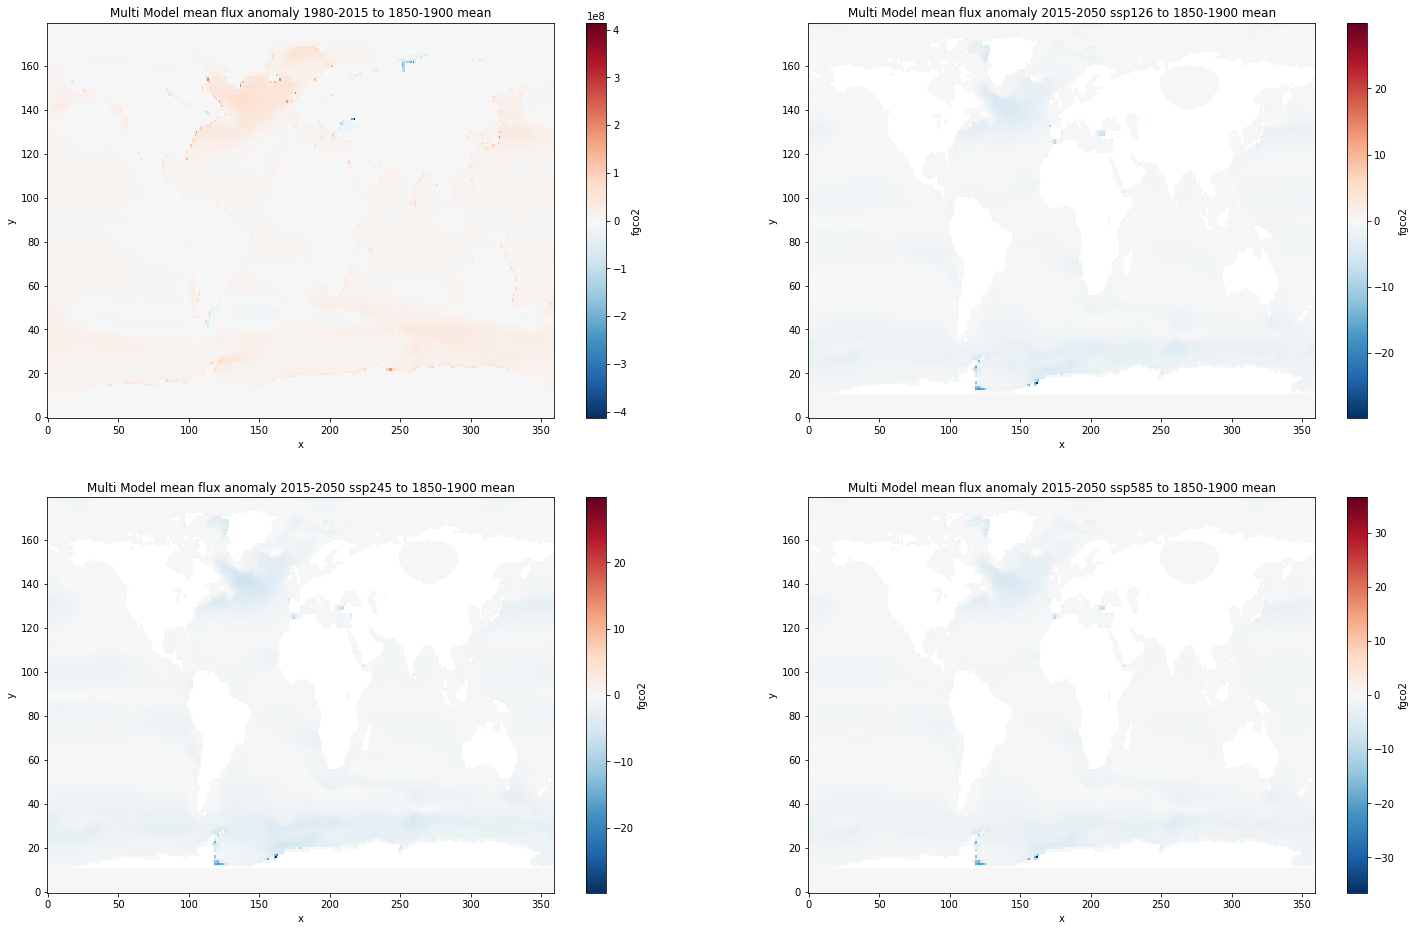

In [34]:
fig= plt.figure(figsize=(25,16))

ax = plt.subplot(2,2,1)
cb= (fgco2_anoms['historical'].mean(dim='source_id')*sec_2_yr).plot()
#  _=ax.coastlines()
ax.set_title('Multi Model mean flux anomaly 1980-2015 to 1850-1900 mean')
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')


ax = plt.subplot(2,2,2)
cb= (fgco2_anoms['ssp126'].mean(dim='source_id')*sec_2_yr).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp126 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')



ax = plt.subplot(2,2,3)
cb= (fgco2_anoms['ssp245'].mean(dim='source_id')*sec_2_yr).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp245 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')


ax = plt.subplot(2,2,4)
cb= (fgco2_anoms['ssp585'].mean(dim='source_id')*sec_2_yr).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp585 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')

# find historical flags

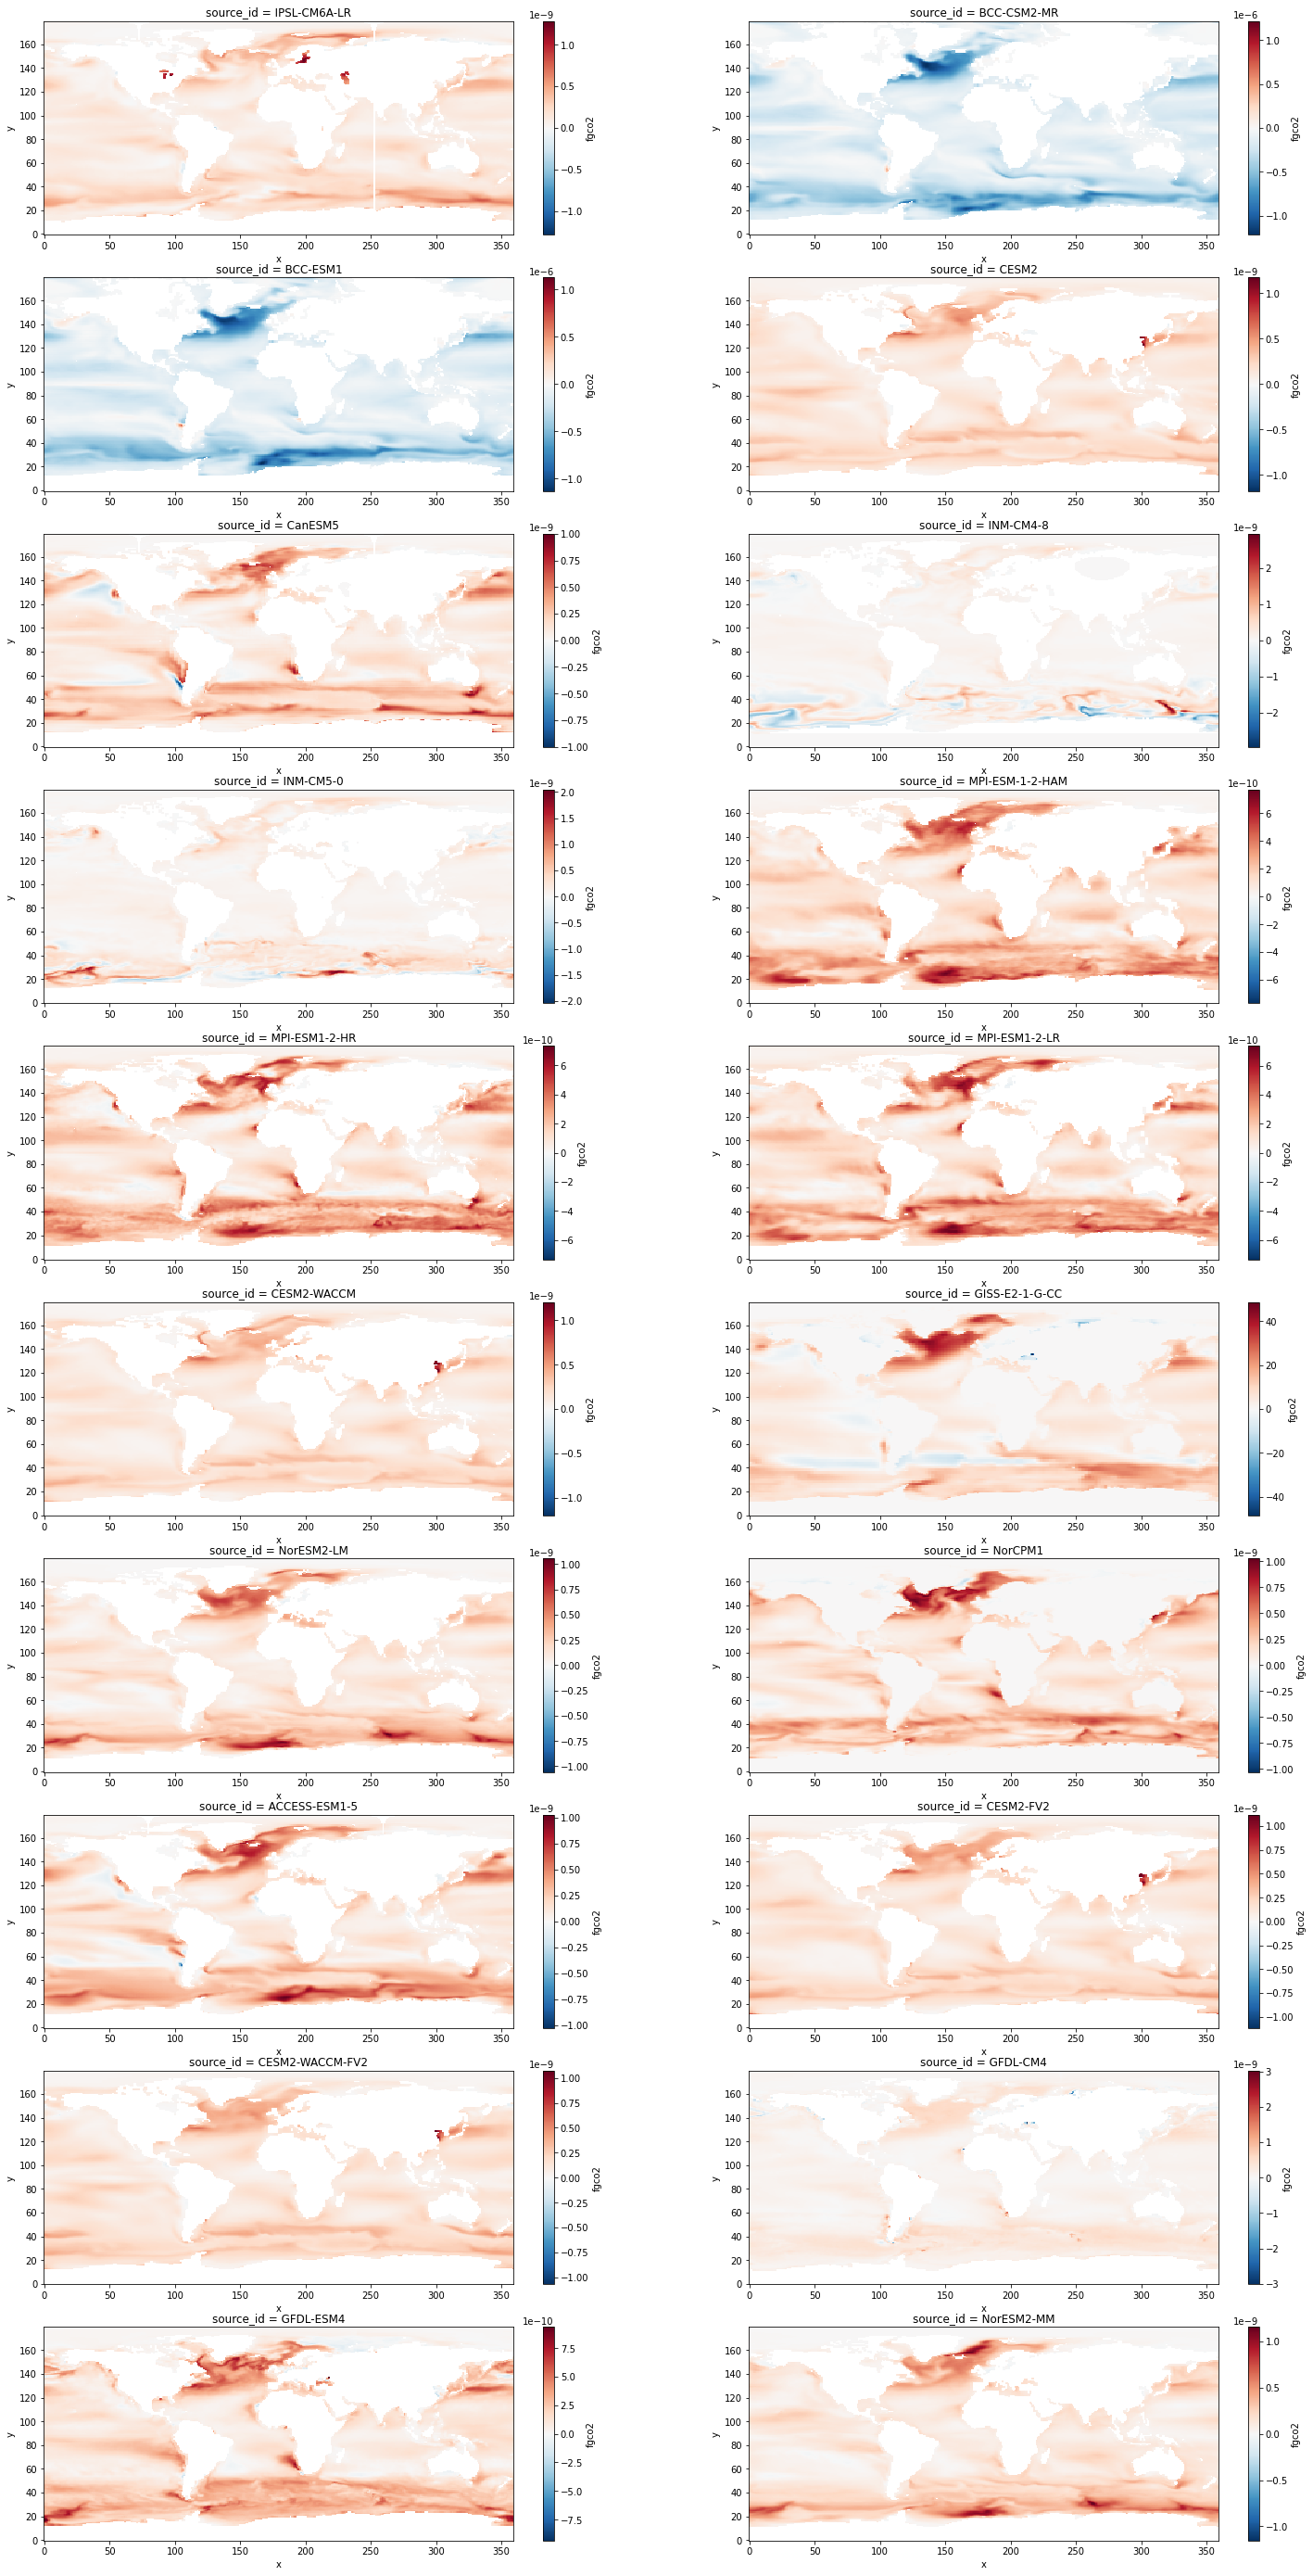

In [48]:
fig= plt.figure(figsize=(25,50))
i = 1

for model in fgco2_anoms['historical'].source_id.values:
    
    ax = plt.subplot(10,2,i)
    fgco2_anoms['historical'].sel( source_id = model).plot()
    i += 1
    

In [60]:
historical_flags =  [fgco2_anoms['historical'].source_id[1].values ,fgco2_anoms['historical'].source_id[2].values]
z_hist = ['gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Omon/fgco2/gn/v20181126/',
    'gs://cmip6/CMIP6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/Omon/fgco2/gn/v20181129/']

In [69]:
hist_flag ={}
for zstore in z_hist:

    model = zstore.split('/')[6]
    mapper = gcs.get_mapper(zstore)
    temp = xr.open_zarr(mapper, consolidated=True)
    hist_flag[model] = temp.fgco2
    
hist_flag

In [89]:
for model in historical_flags:
    
    fgco2_anom_dicts['historical'][str(model)] = fgco2_anom_dicts['historical'][str(model)] * -12/44
    
# converting to kg of C instead of CO2 and changing the sign


# Find ssp126 flags

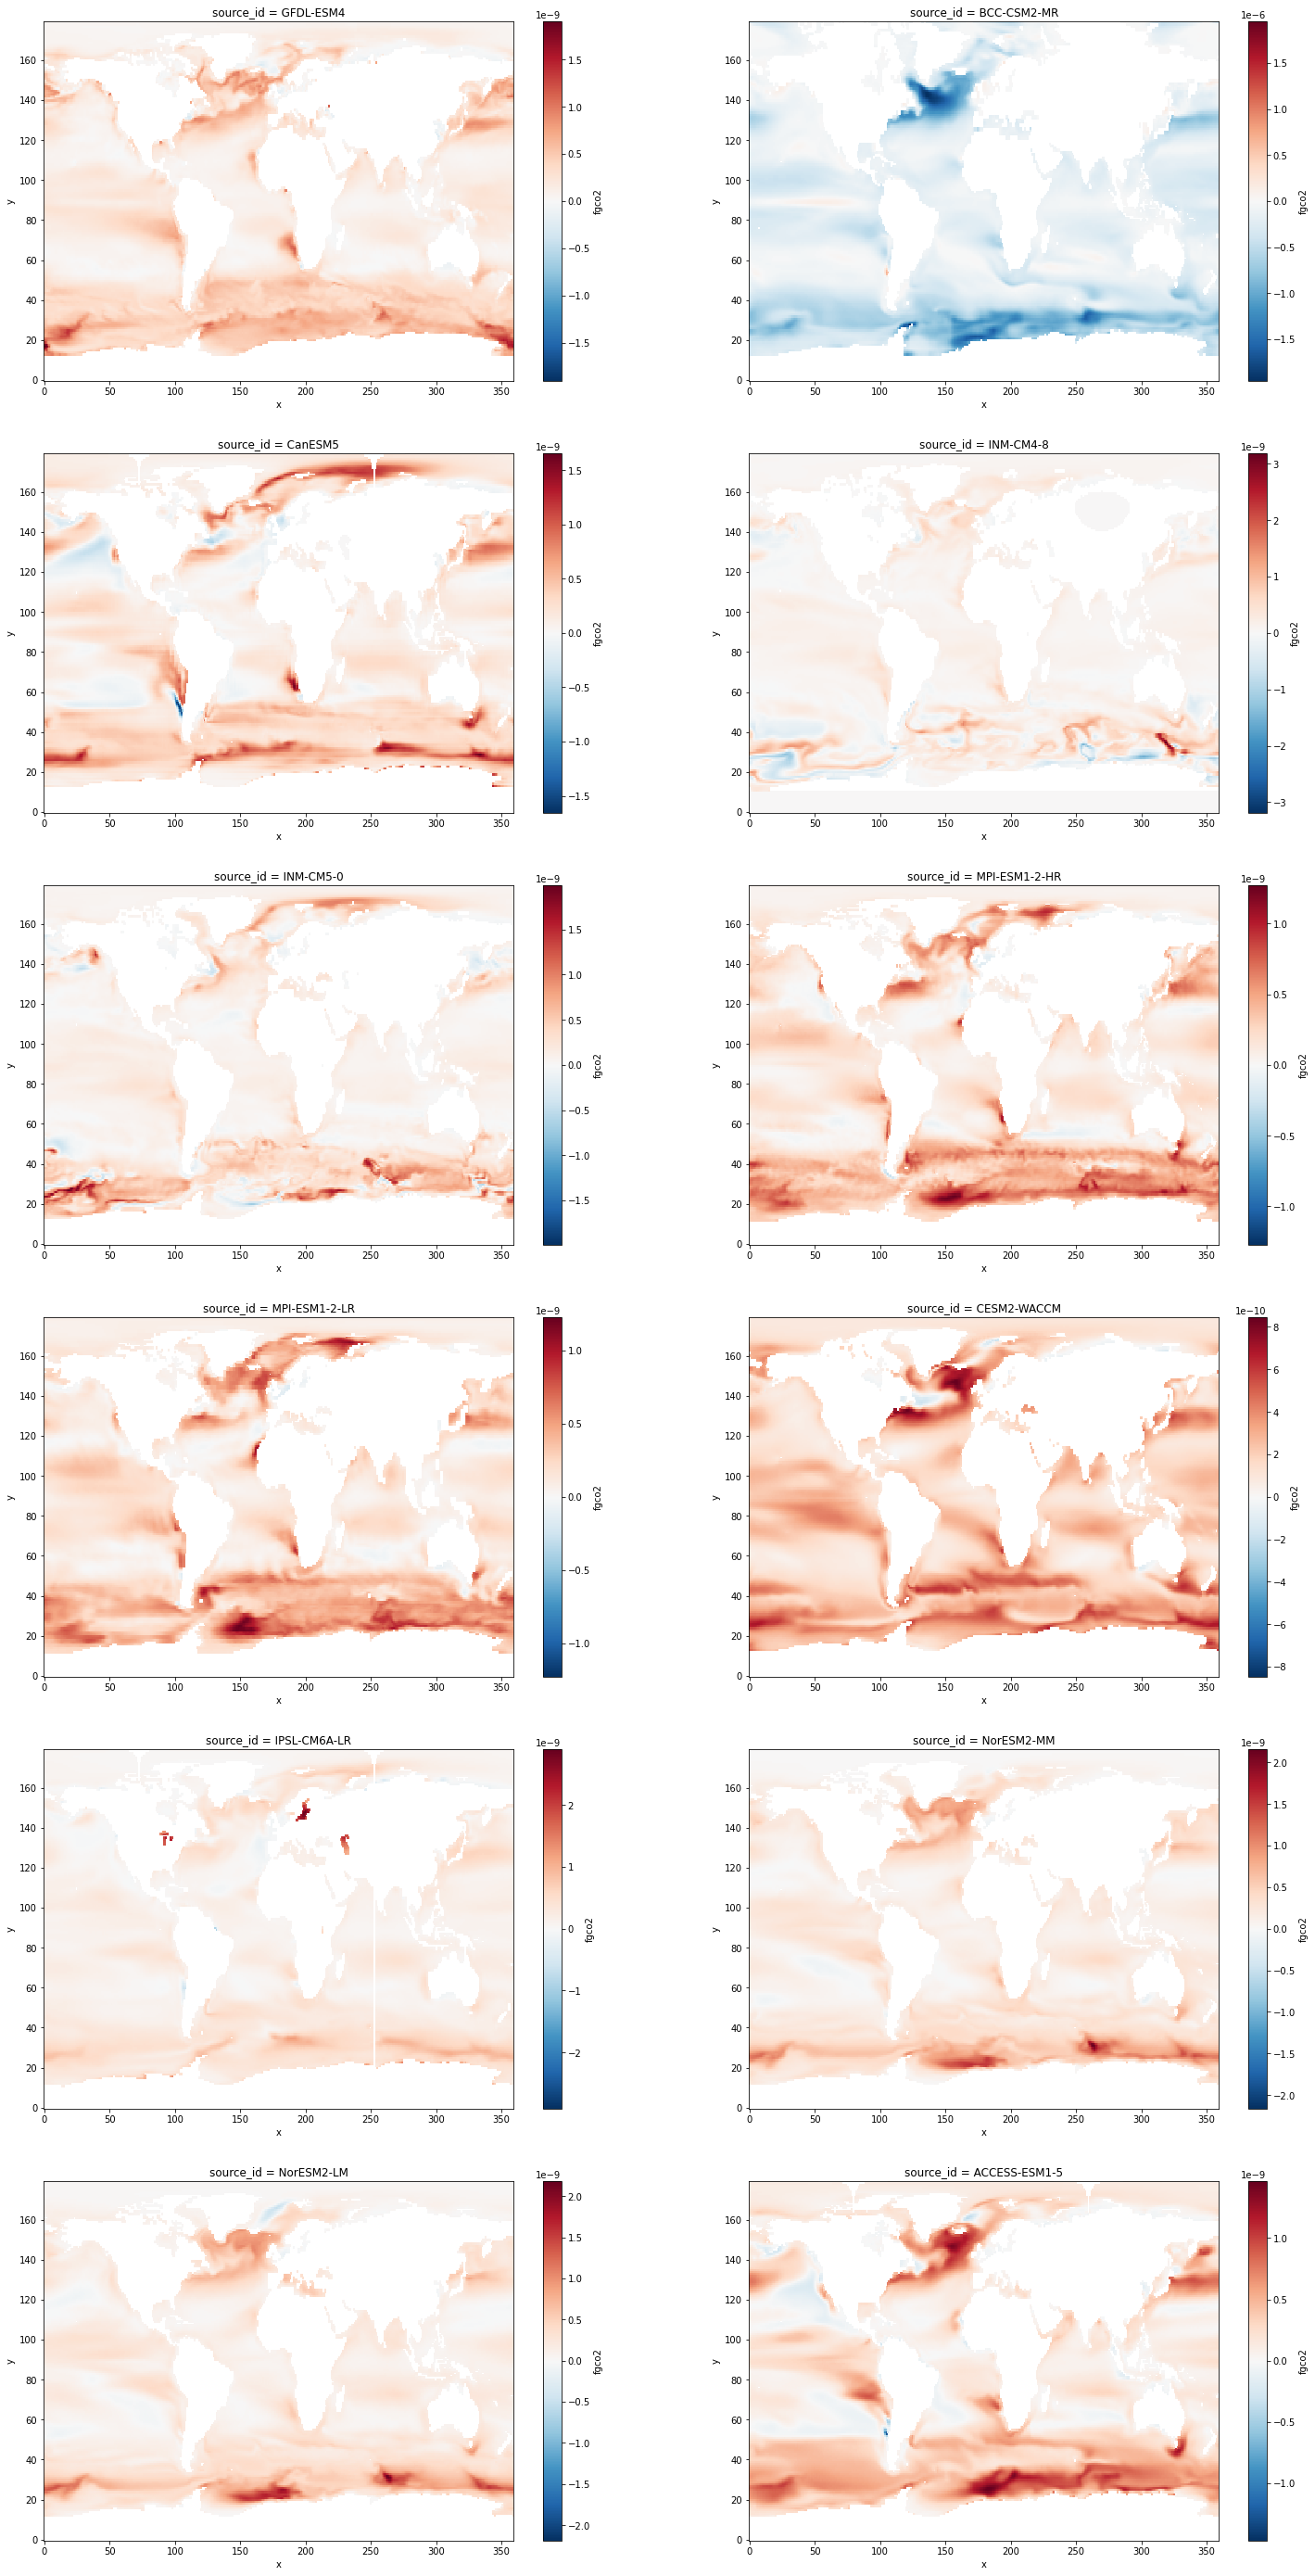

In [93]:
fig= plt.figure(figsize=(25,50))
i = 1

for model in fgco2_anoms['ssp126'].source_id.values:
    
    ax = plt.subplot(6,2,i)
    fgco2_anoms['ssp126'].sel( source_id = model).plot()
    i += 1
    

In [94]:
ssp126_flags = [fgco2_anoms['ssp126'].source_id[1].values]
z = ['gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp126/r1i1p1f1/Omon/fgco2/gn/v20190319/']

flag ={}
for zstore in z:

    model = zstore.split('/')[6]
    mapper = gcs.get_mapper(zstore)
    temp = xr.open_zarr(mapper, consolidated=True)
    flag[model] = temp.fgco2
    
flag

{'BCC-CSM2-MR': <xarray.DataArray 'fgco2' (time: 1980, lat: 232, lon: 360)>
 dask.array<xarray-fgco2, shape=(1980, 232, 360), dtype=float32, chunksize=(120, 232, 360), chunktype=numpy.ndarray>
 Coordinates:
     depth      float64 ...
   * lat        (lat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
     latitude   (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
   * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
     longitude  (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
   * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
 Attributes:
     cell_measures:  area: areacello
     cell_methods:   area: mean where sea time: mean (interval: 30 minutes)
     comment:        Gas exchange flux of CO2 (positive into ocean)
     history:        2018-11-26T09:02:53Z altered by CMOR: Treated scalar dime...
     long_name:      Surface Downward Flux of Total CO2
     original_name:  fgco2
     s

In [95]:
for model in ssp126_flags:
    
    fgco2_anom_dicts['ssp126'][str(model)] = fgco2_anom_dicts['ssp126'][str(model)] * -12/44
    
# converting to kg of C instead of CO2 and changing the sign


# ssp245 flags

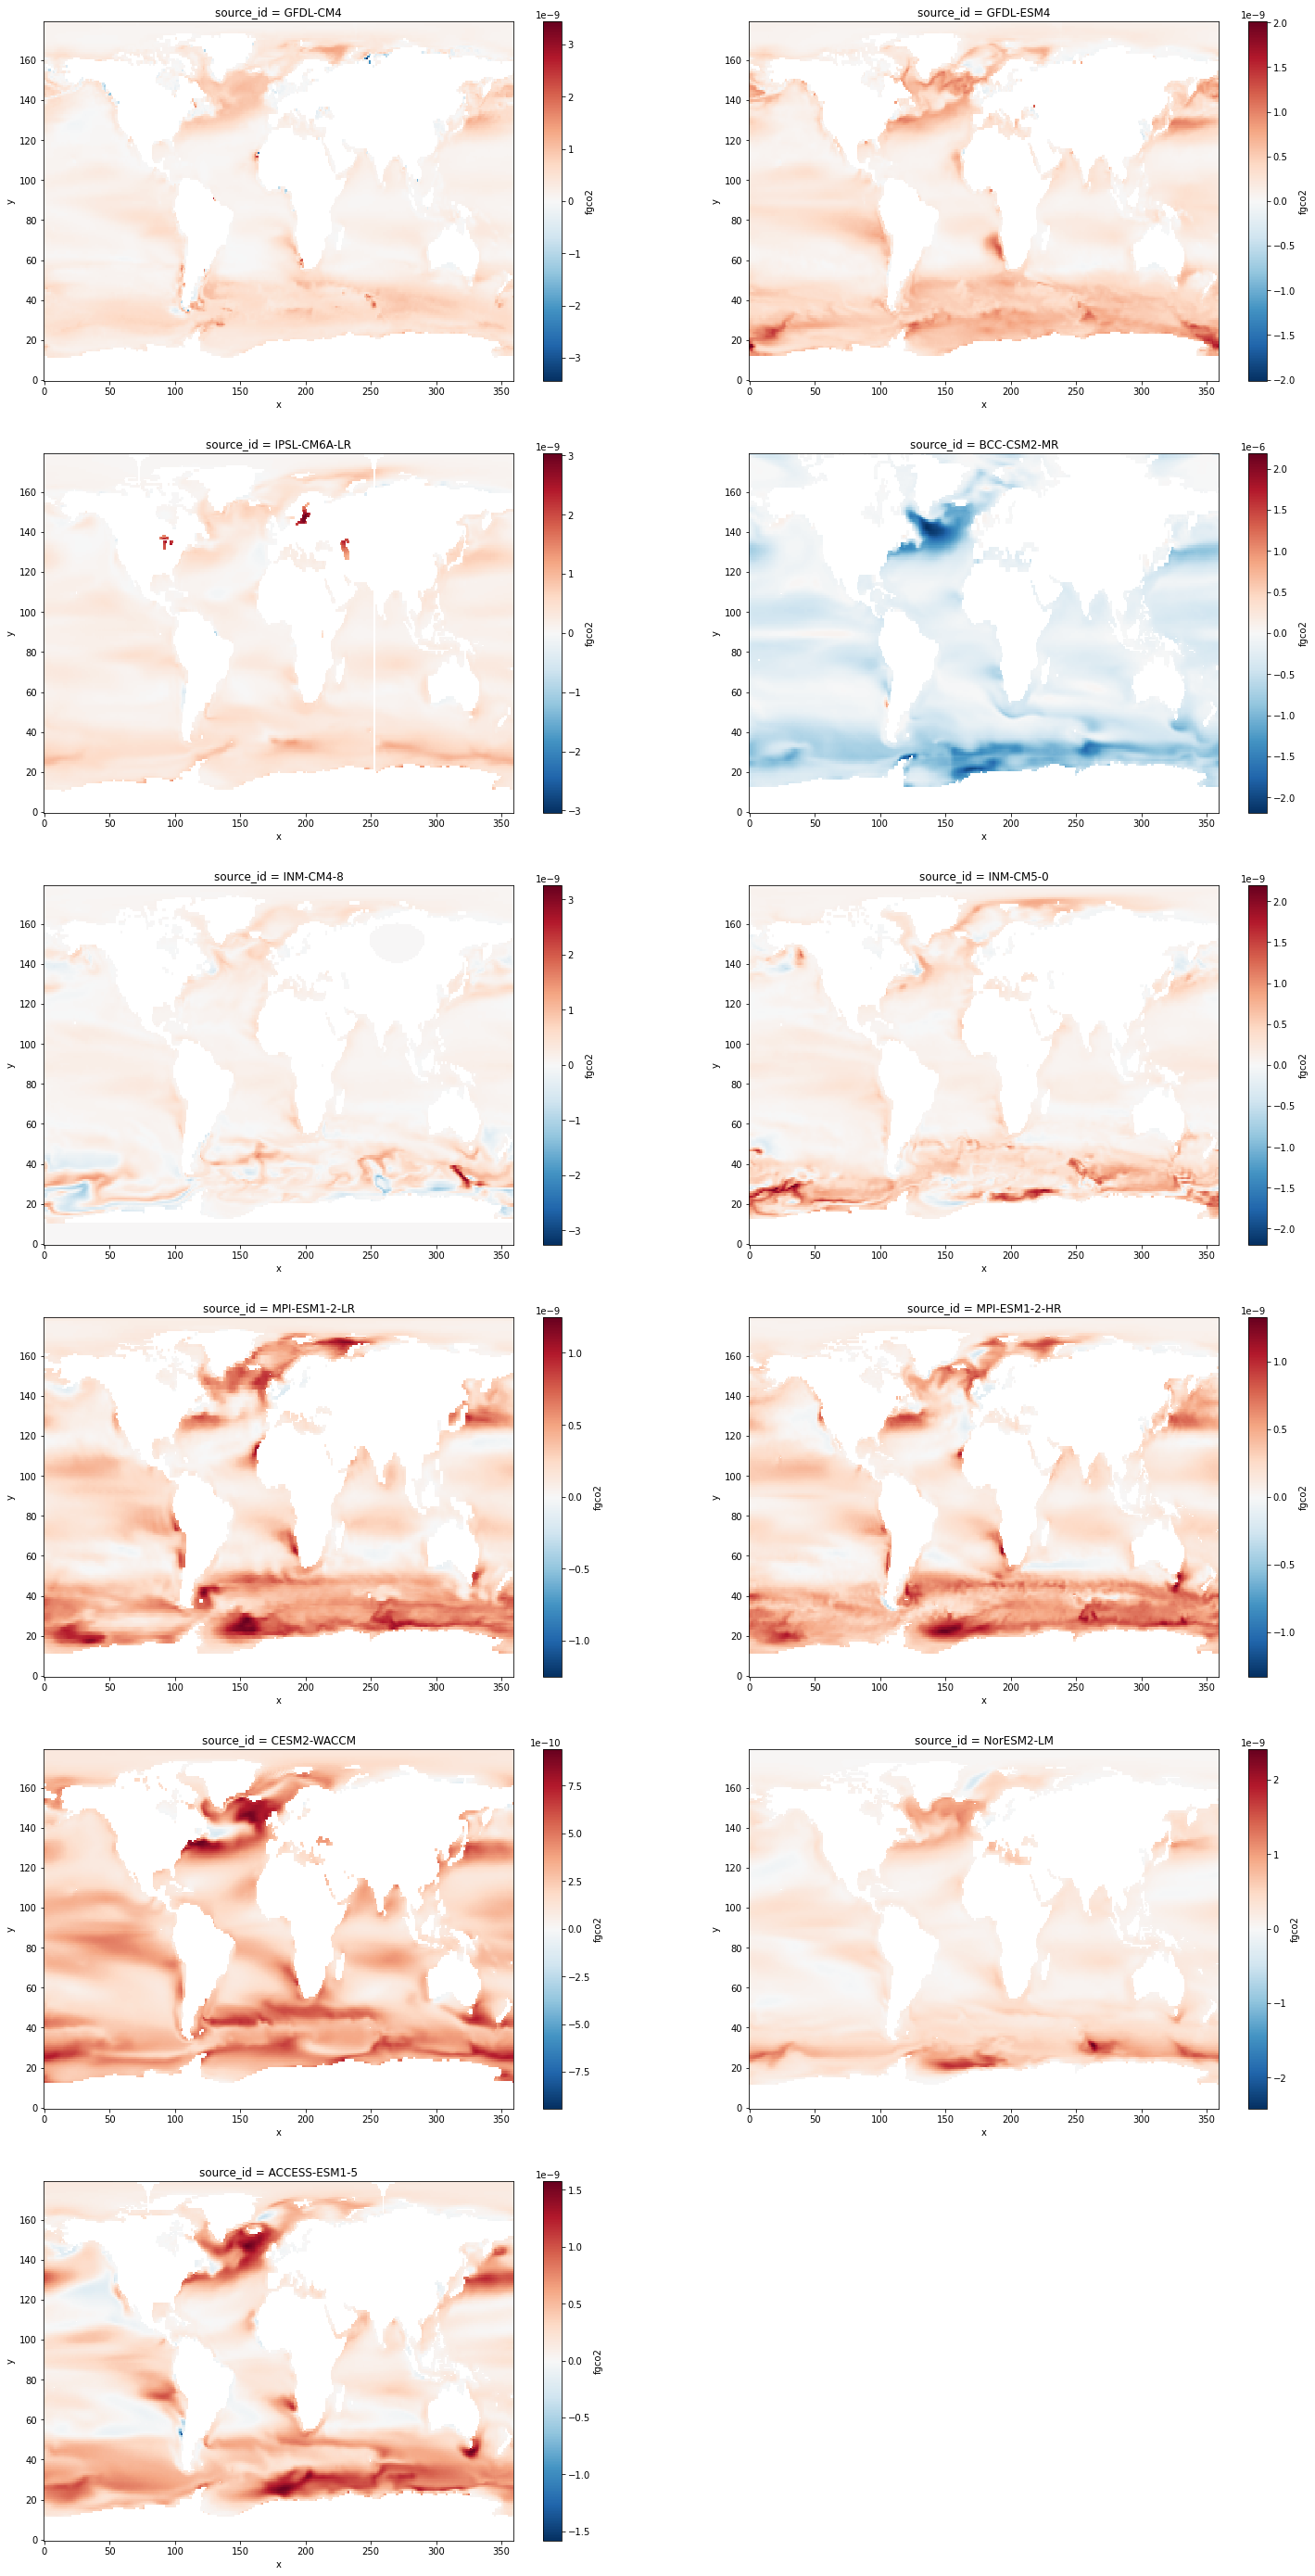

In [97]:
fig= plt.figure(figsize=(25,50))
i = 1

for model in fgco2_anoms['ssp245'].source_id.values:
    
    ax = plt.subplot(6,2,i)
    fgco2_anoms['ssp245'].sel( source_id = model).plot()
    i += 1

In [101]:
ssp245_flags = [fgco2_anoms['ssp245'].source_id[3].values]
z = ['gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp245/r1i1p1f1/Omon/fgco2/gn/v20190319/']



In [103]:
for model in ssp245_flags:
    
    fgco2_anom_dicts['ssp245'][str(model)] = fgco2_anom_dicts['ssp245'][str(model)] * -12/44
    
# converting to kg of C instead of CO2 and changing the sign

# Flag ssp585

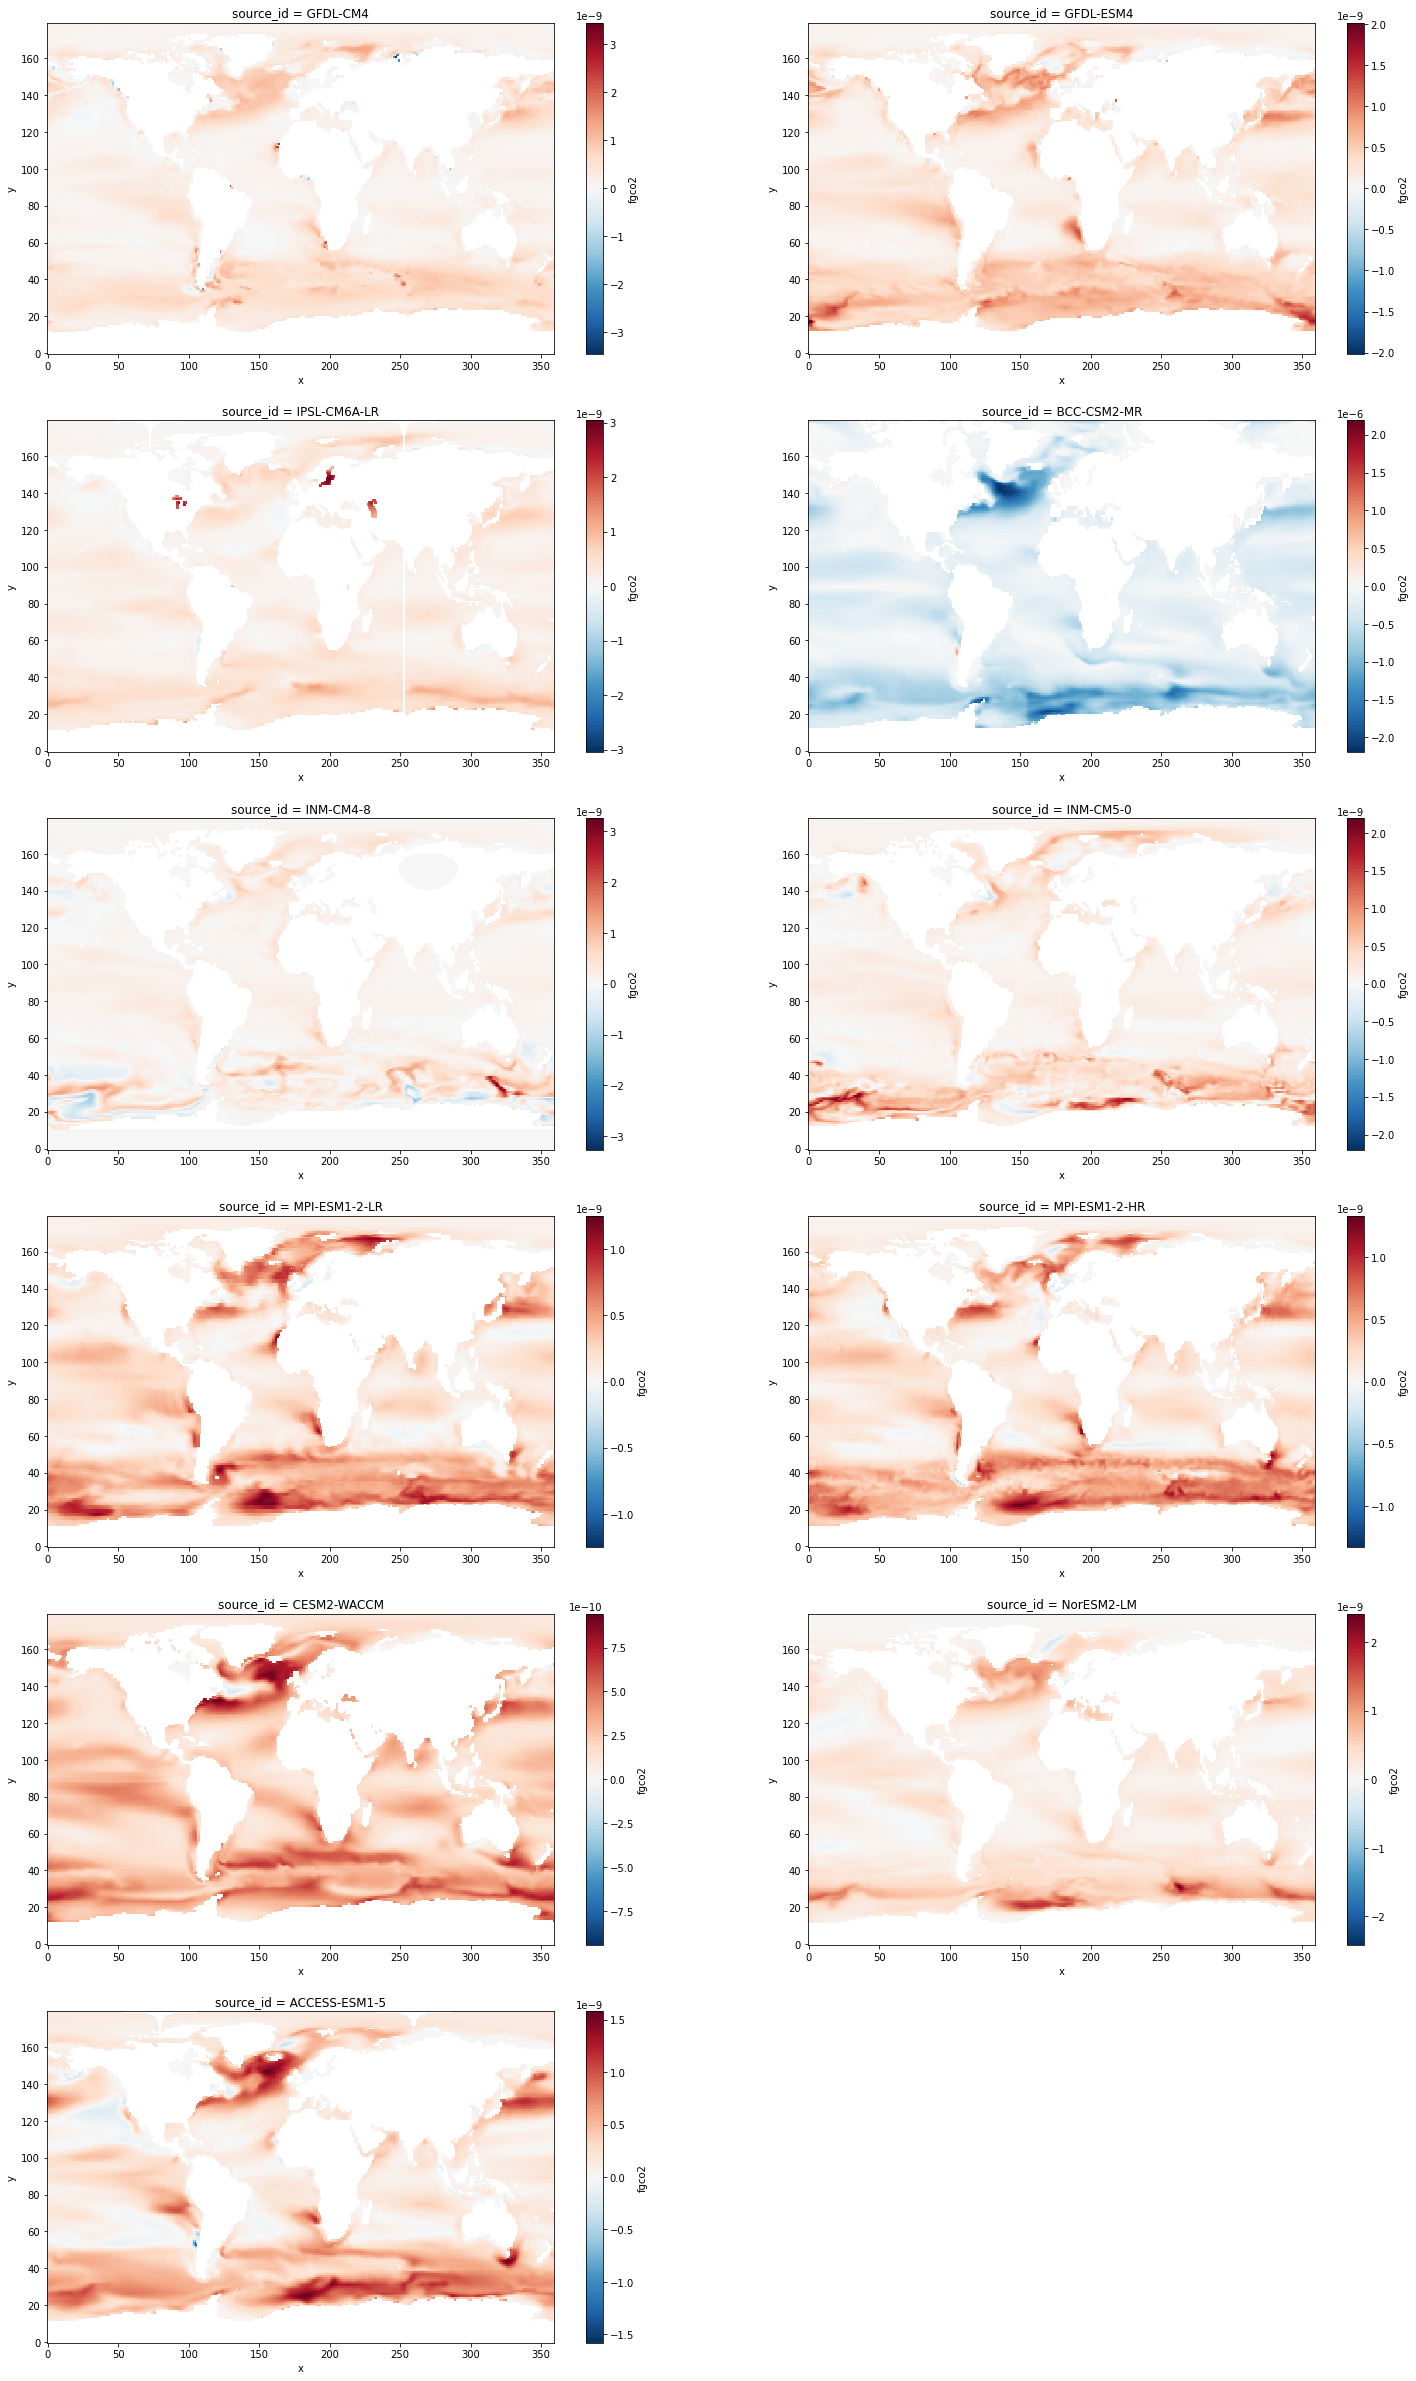

In [105]:
fig= plt.figure(figsize=(25,50))
i = 1

for model in fgco2_anoms['ssp245'].source_id.values:
    
    ax = plt.subplot(7,2,i)
    fgco2_anoms['ssp245'].sel( source_id = model).plot()
    i += 1

In [108]:
ssp585_flags = [fgco2_anoms['ssp585'].source_id[3].values]
z = ['gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/r1i1p1f1/Omon/fgco2/gn/v20190319/']



In [109]:
for model in ssp585_flags:
    
    fgco2_anom_dicts['ssp585'][str(model)] = fgco2_anom_dicts['ssp585'][str(model)] * -12/44
    
# converting to kg of C instead of CO2 and changing the sign

# Correcting the xarray

In [111]:
fgco2_anoms_corrected = {}
for exp, dic in fgco2_anom_dicts.items():
    dss = [ds for key, ds in dic.items()]
    fgco2_anoms_corrected[exp] = xr.concat(dss, dim='source_id').assign_coords(source_id=list(dic.keys())).load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Multi Model mean flux anomaly 2015-2050 ssp585 to 1850-1900 mean')

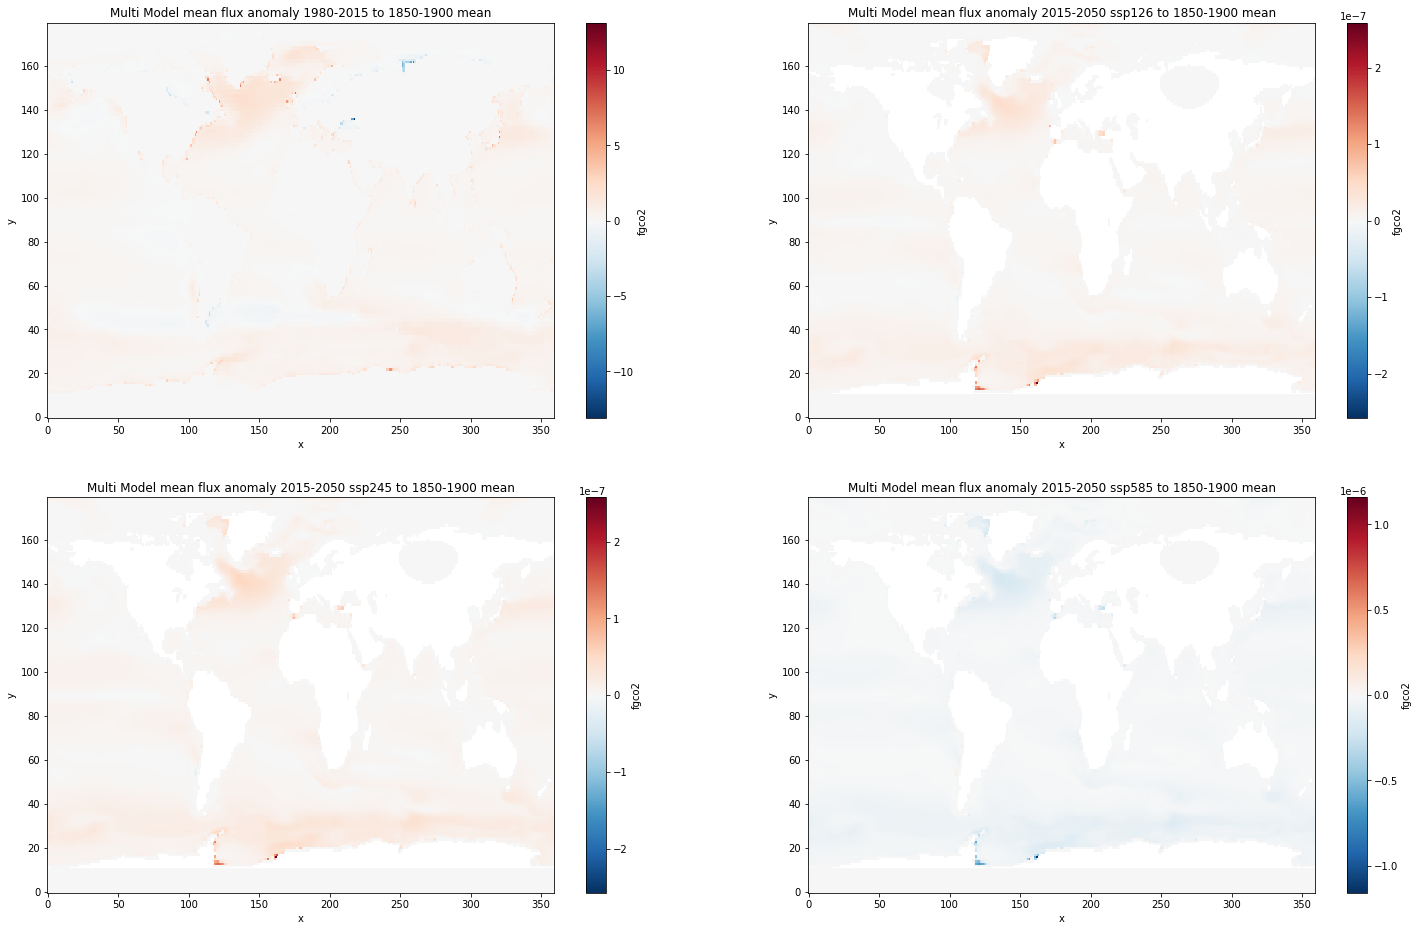

In [113]:
fig= plt.figure(figsize=(25,16))

ax = plt.subplot(2,2,1)
cb= (fgco2_anoms_corrected['historical'].mean(dim='source_id')).plot()
#  _=ax.coastlines()
ax.set_title('Multi Model mean flux anomaly 1980-2015 to 1850-1900 mean')
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')


ax = plt.subplot(2,2,2)
cb= (fgco2_anoms_corrected['ssp126'].mean(dim='source_id')).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp126 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')



ax = plt.subplot(2,2,3)
cb= (fgco2_anoms_corrected['ssp245'].mean(dim='source_id')).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp245 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')


ax = plt.subplot(2,2,4)
cb= (fgco2_anoms_corrected['ssp585'].mean(dim='source_id')).plot()
ax.set_title('Multi Model mean flux anomaly 2015-2050 ssp585 to 1850-1900 mean')
#  _=ax.coastlines()
# divider = make_axes_locatable(ax)
# ax_cb = divider.append_axes('bottom', size="3%", pad=0.1, axes_class=plt.Axes)
# _=plt.colorbar(cb, cax=ax_cb, orientation="horizontal", label=r'Ocean carbon flux (mol m$^{-2}$ yr$^{-1}$)')

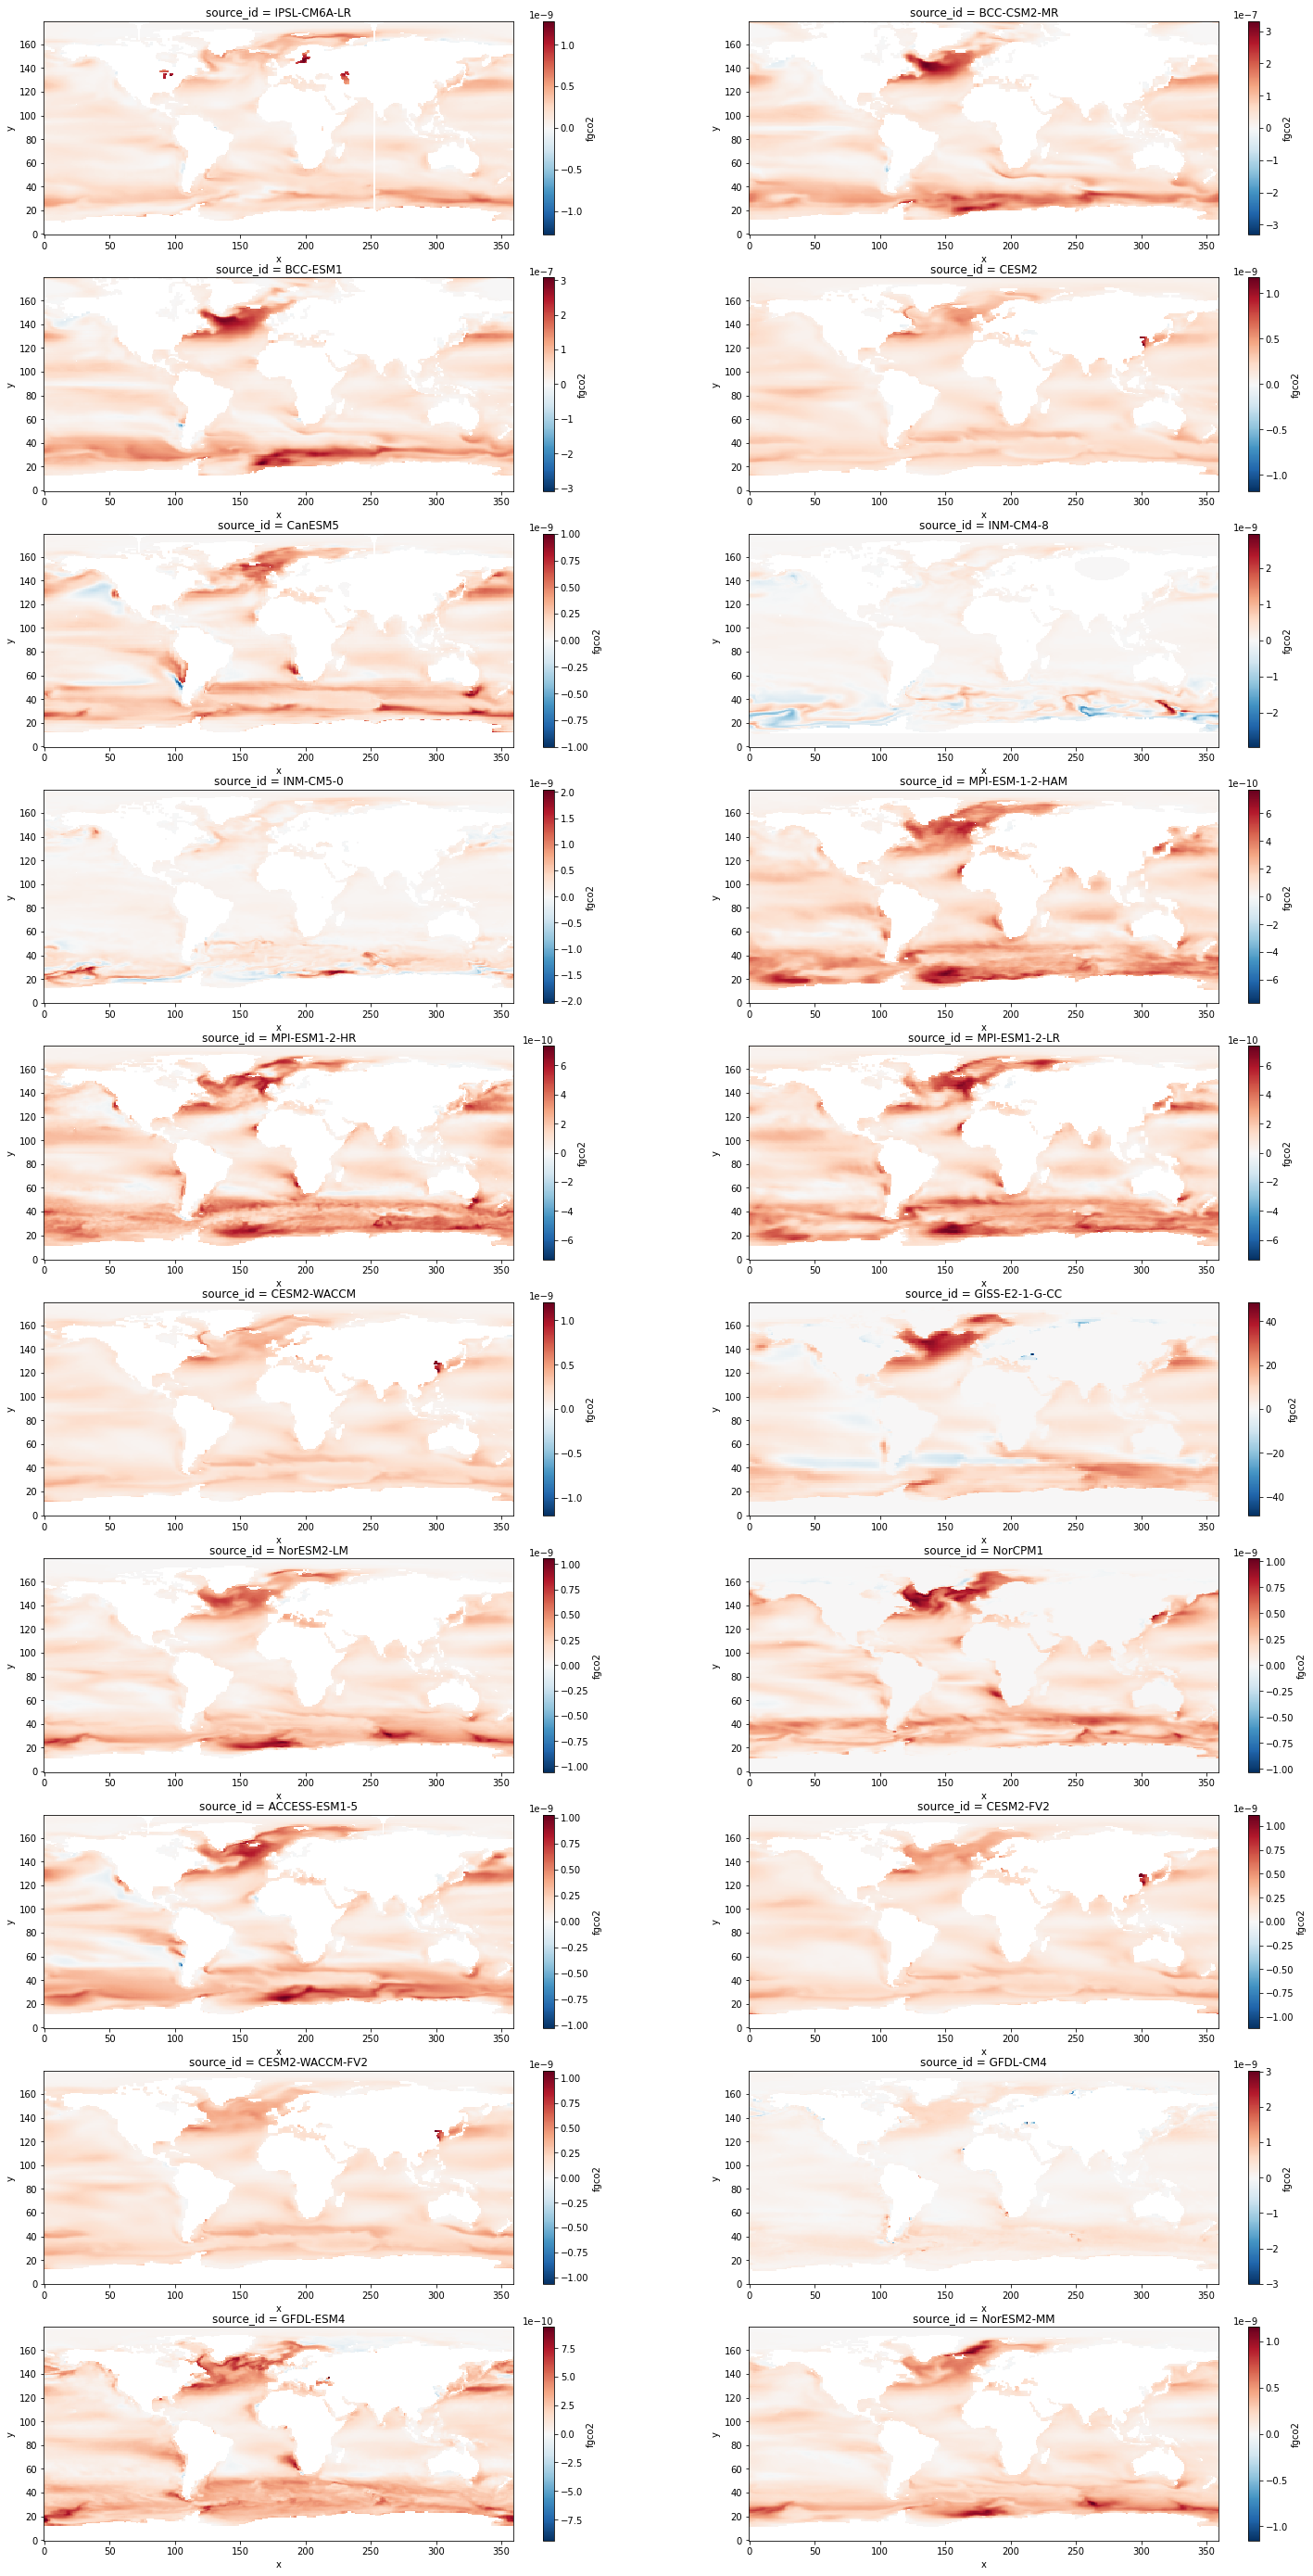

In [114]:
fig= plt.figure(figsize=(25,50))
i = 1

for model in fgco2_anoms_corrected['historical'].source_id.values:
    
    ax = plt.subplot(10,2,i)
    fgco2_anoms_corrected['historical'].sel( source_id = model).plot()
    i += 1